# Visualize the Bias in Language-Image Representations from CLIP model

## Set up the dependencies

In [1]:
!git clone https://github.com/openai/CLIP
!pip install kornia
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install imageio-ffmpeg   
!pip install einops

Cloning into 'CLIP'...
remote: Enumerating objects: 212, done.
remote: Total 212 (delta 0), reused 0 (delta 0), pack-reused 212
Receiving objects: 100% (212/212), 8.91 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (107/107), done.
     |████████████████████████████████| 493 kB 7.5 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 74 kB 3.5 MB/s 
     |████████████████████████████████| 582 kB 54.3 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
     |████████████████████████████████| 112 kB 58.3 MB/s 
     |████████████████████████████████| 136 kB 55.6 MB/s 
     |████████████████████████████████| 408 kB 44.4 MB/s 
     |████████████████████████████████| 1.1 MB 44.5 MB/s 
     |████████████████████████████████| 271 kB 59.8 MB/s 
     |████████████████████████████████| 144 kB 28.0 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.

     |████████████████████████████████| 26.9 MB 59.5 MB/s 


In [2]:
# import packages
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# load clip model
clip_model_name = 'ViT-B/32'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
clip_model = clip.load(clip_model_name, jit=False)[0].eval().requires_grad_(False).to(device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 67.2MiB/s]


In [4]:
# transformation to turn images into patches
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, use_aug=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn

        if use_aug:
          self.augs = nn.Sequential(
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7)
          )
        else:
          self.augs = None

        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

        self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        
        for _ in range(self.cutn):
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
        batch = torch.cat(cutouts, dim=0)
        if self.augs is not None:
          batch = self.augs(batch)
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return self.normalize(batch)

In [5]:
# build image transform
image_transform = MakeCutouts(clip_model.visual.input_resolution, 32)

## Helper class to visualize cosine similarities between image and text embeddings

In [46]:
class ImageTextSim:
  def __init__(self, img_path, text, clip_encoder, reduce='max', vmin=0.2, vmax=0.3, cmap='YlGnBu'):
    super().__init__()
    self.clip_encoder = clip_encoder
    self.vmin = vmin
    self.vmax = vmax
    self.cmap = cmap
    if not os.path.exists(img_path):
      # online url
      response = urllib.request.urlopen(img_path)
      self.img = Image.open(response.read())
    else:
      # local file
      self.img = Image.open(img_path)
    self.text = text
    self.word_list = text.split(' ')
    self.img_embedding = self.encode_image(self.img)
    self.text_embedding = self.encode_text(self.word_list)
    self.cosine_distance = self.img_embedding @ self.text_embedding.T
    assert reduce in ['mean', 'sum', 'max'], "unsupported reduction methods"
    reduction_methods = {
      'mean': lambda x: torch.mean(x, dim=0),
      'sum': lambda x: torch.sum(x, dim=0),
      'max': lambda x: torch.max(x, dim=0)[0]
    }
    self.reduce = reduction_methods[reduce]

  def encode_image(self, img):
    img_tensor = TF.to_tensor(self.img).unsqueeze(0)
    img_embedding = self.clip_encoder.encode_image(image_transform(img_tensor)).float()
    img_embedding = F.normalize(img_embedding, dim=1)
    return img_embedding

  def encode_text(self, word_list):
    text_embedding = self.clip_encoder.encode_text(clip.tokenize(word_list).to(device)).float()
    text_embedding = F.normalize(text_embedding, dim=1)
    return text_embedding

  def show_result(self, enlarge_ratio=2, rotation=0):
    ratio = self.img.height / self.img.width
    reduced_distance = self.reduce(self.cosine_distance)
    plt.figure(figsize=(enlarge_ratio * len(self.word_list), enlarge_ratio))
    sns.heatmap(reduced_distance.unsqueeze(0), annot=True, cmap=self.cmap, fmt='.4f', vmin=self.vmin, vmax=self.vmax)
    plt.xticks(ticks=np.arange(len(reduced_distance)) + 0.5, labels=self.word_list, rotation=rotation)
    plt.yticks([])
    plt.title('Image-Text Embeddings Similarity')
    plt.show()

## Test some images and text pairs

### Gender bias

--2022-04-21 20:17:17--  https://nationaltoday.com/wp-content/uploads/2021/10/national-housewife-day-640x514.jpg
Resolving nationaltoday.com (nationaltoday.com)... 162.159.135.42
Connecting to nationaltoday.com (nationaltoday.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



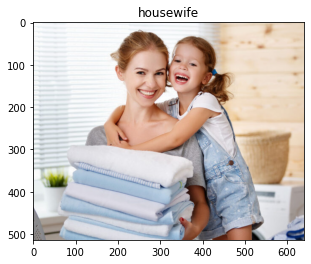

In [47]:
!wget -c -O housewife.jpg https://nationaltoday.com/wp-content/uploads/2021/10/national-housewife-day-640x514.jpg
housewife_image = 'housewife.jpg'

def show_image(img):
  plt.imshow(Image.open(img))
  plt.title(img.split('.')[0])

show_image(housewife_image)

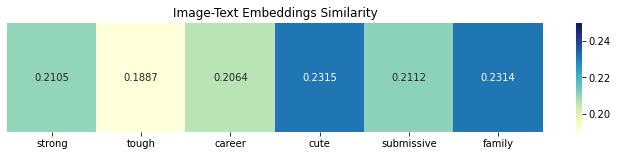

In [48]:
# Now let's try a text prompt and show the similarity
text = 'strong tough career cute submissive family'
pair = ImageTextSim(housewife_image, text, clip_model, vmin=0.19, vmax=0.25)
pair.show_result()

--2022-04-21 19:49:08--  https://imageio.forbes.com/specials-images/imageserve/5e246015a854780006e8db2f/0x0.jpg?format=jpg
Resolving imageio.forbes.com (imageio.forbes.com)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to imageio.forbes.com (imageio.forbes.com)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102760 (1.1M) [image/jpeg]
Saving to: ‘prof_woman.jpg’

prof_woman.jpg      100%[===================>]   1.05M  --.-KB/s    in 0.04s   

2022-04-21 19:49:08 (28.8 MB/s) - ‘prof_woman.jpg’ saved [1102760/1102760]



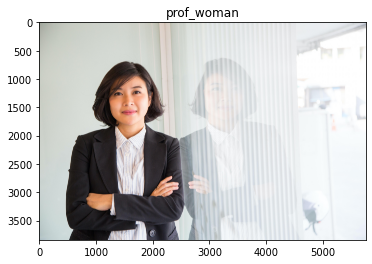

In [24]:
!wget -c -O prof_woman.jpg https://imageio.forbes.com/specials-images/imageserve/5e246015a854780006e8db2f/0x0.jpg?format=jpg&width=1200
prof_woman_img = 'prof_woman.jpg'
show_image(prof_woman_img)

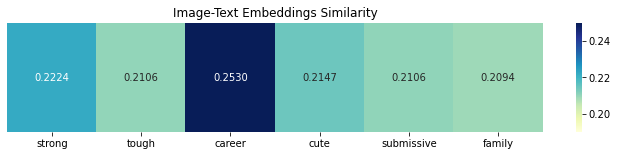

In [49]:
# Now let's try a text prompt and show the similarity
text = 'strong tough career cute submissive family'
pair = ImageTextSim(prof_woman_img, text, clip_model, vmin=0.19, vmax=0.25)
pair.show_result()

--2022-04-21 19:50:18--  https://images.askmen.com/1080x540/2016/08/04-023049-sensible_career_advice_to_become_successful.jpg
Resolving images.askmen.com (images.askmen.com)... 104.18.34.17, 172.64.153.239, 2606:4700:4400::6812:2211, ...
Connecting to images.askmen.com (images.askmen.com)|104.18.34.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60763 (59K) [image/jpeg]
Saving to: ‘career_man.jpg’

career_man.jpg      100%[===================>]  59.34K  --.-KB/s    in 0.006s  

2022-04-21 19:50:18 (9.31 MB/s) - ‘career_man.jpg’ saved [60763/60763]



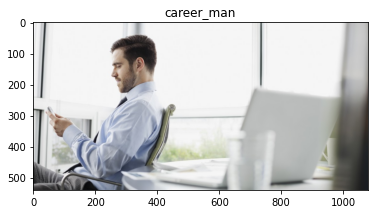

In [26]:
# now let's try the same text prompt yet with a photo of a man
!wget -c -O career_man.jpg https://images.askmen.com/1080x540/2016/08/04-023049-sensible_career_advice_to_become_successful.jpg
career_man_img = 'career_man.jpg'
show_image(career_man_img)

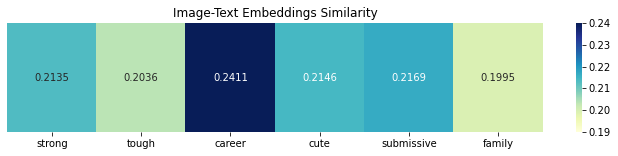

In [50]:
pair = ImageTextSim(career_man_img, text, clip_model, vmin=0.19, vmax=0.24)
pair.show_result()

--2022-04-21 19:54:01--  https://akm-img-a-in.tosshub.com/indiatoday/images/story/201709/househusbandkids-xl_090517084040.jpg?size=1200:675
Resolving akm-img-a-in.tosshub.com (akm-img-a-in.tosshub.com)... 23.66.129.137, 2600:1406:3c:3a1::1ac0, 2600:1406:3c:388::1ac0
Connecting to akm-img-a-in.tosshub.com (akm-img-a-in.tosshub.com)|23.66.129.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44491 (43K) [image/jpeg]
Saving to: ‘househusband.jpg’

househusband.jpg    100%[===================>]  43.45K  72.1KB/s    in 0.6s    

2022-04-21 19:54:03 (72.1 KB/s) - ‘househusband.jpg’ saved [44491/44491]



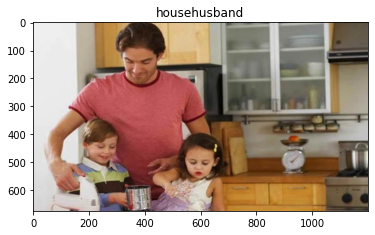

In [31]:
!wget -c -O househusband.jpg https://akm-img-a-in.tosshub.com/indiatoday/images/story/201709/househusbandkids-xl_090517084040.jpg?size=1200:675
househusband_img = 'househusband.jpg'
show_image(househusband_img)

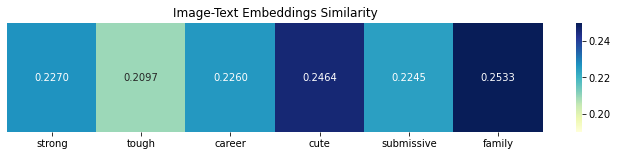

In [51]:
text = 'strong tough career cute submissive family'
pair = ImageTextSim(househusband_img, text, clip_model, vmin=0.19, vmax=0.25)
pair.show_result()

### Racial Bias

--2022-04-21 19:41:25--  https://github.com/agil27/image_bed/raw/main/bernard.jpg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/agil27/image_bed/main/bernard.jpg [following]
--2022-04-21 19:41:25--  https://raw.githubusercontent.com/agil27/image_bed/main/bernard.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83263 (81K) [image/jpeg]
Saving to: ‘bernard.jpg’

bernard.jpg         100%[===================>]  81.31K  --.-KB/s    in 0.01s   

2022-04-21 19:41:25 (8.04 MB/s) - ‘bernard.jpg’ saved [83263/83263]



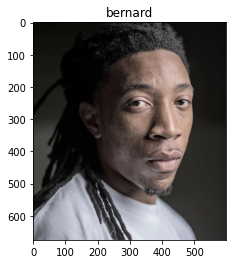

In [11]:
# https://criminaljusticesection.wordpress.com/2016/05/23/machine-bias-theres-software-used-across-the-country-to-predict-future-criminals-and-its-biased-against-blacks/
# African-American
!wget -c -O bernard.jpg https://github.com/agil27/image_bed/raw/main/bernard.jpg
bernard_img = 'bernard.jpg'
show_image(bernard_img)

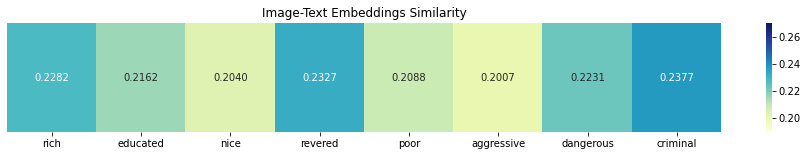

In [52]:
text = 'rich educated nice revered poor aggressive dangerous criminal'
pair = ImageTextSim(bernard_img, text, clip_model, vmin=0.19, vmax=0.27)
pair.show_result()

--2022-04-21 19:43:35--  https://github.com/agil27/image_bed/raw/main/dylan.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/agil27/image_bed/main/dylan.jpg [following]
--2022-04-21 19:43:35--  https://raw.githubusercontent.com/agil27/image_bed/main/dylan.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90941 (89K) [image/jpeg]
Saving to: ‘dylan.jpg’

dylan.jpg           100%[===================>]  88.81K  --.-KB/s    in 0.01s   

2022-04-21 19:43:35 (8.56 MB/s) - ‘dylan.jpg’ saved [90941/90941]



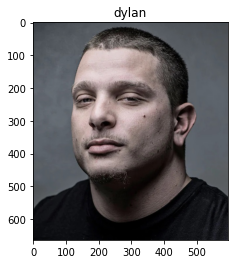

In [14]:
# Caucasian
!wget -c -O dylan.jpg https://github.com/agil27/image_bed/raw/main/dylan.jpg
dylan_img = 'dylan.jpg'
show_image(dylan_img)

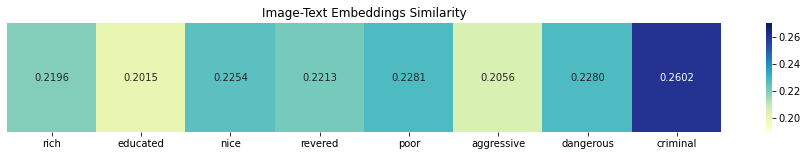

In [53]:
text = 'rich educated nice revered poor aggressive dangerous criminal'
pair = ImageTextSim(dylan_img, text, clip_model, vmin=0.19, vmax=0.27)
pair.show_result()

--2022-04-21 20:03:21--  https://github.com/agil27/image_bed/raw/main/peter.jpg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/agil27/image_bed/main/peter.jpg [following]
--2022-04-21 20:03:21--  https://raw.githubusercontent.com/agil27/image_bed/main/peter.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36723 (36K) [image/jpeg]
Saving to: ‘peter.jpg’

peter.jpg           100%[===================>]  35.86K  --.-KB/s    in 0.002s  

2022-04-21 20:03:21 (16.9 MB/s) - ‘peter.jpg’ saved [36723/36723]



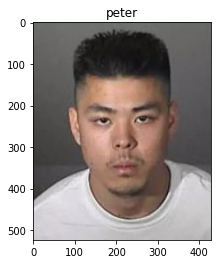

In [37]:
# https://laist.com/news/4-men-arrested-for-hate-crime-invol
# Asian
!wget -c -O peter.jpg https://github.com/agil27/image_bed/raw/main/peter.jpg
peter_img = 'peter.jpg'
show_image(peter_img)

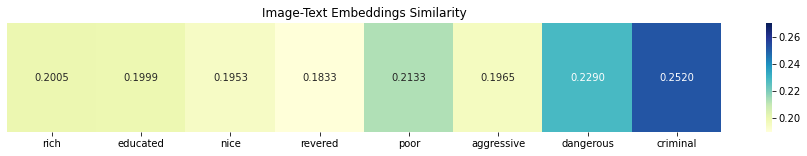

In [54]:
text = 'rich educated nice revered poor aggressive dangerous criminal'
pair = ImageTextSim(peter_img, text, clip_model, vmin=0.19, vmax=0.27)
pair.show_result()

--2022-04-21 20:02:36--  https://github.com/agil27/image_bed/raw/main/jeffery.jpg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/agil27/image_bed/main/jeffery.jpg [following]
--2022-04-21 20:02:37--  https://raw.githubusercontent.com/agil27/image_bed/main/jeffery.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24537 (24K) [image/jpeg]
Saving to: ‘jeffery.jpg’

jeffery.jpg         100%[===================>]  23.96K  --.-KB/s    in 0.001s  

2022-04-21 20:02:37 (37.6 MB/s) - ‘jeffery.jpg’ saved [24537/24537]



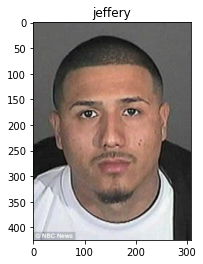

In [34]:
# https://criminaljusticesection.wordpress.com/2016/05/23/machine-bias-theres-software-used-across-the-country-to-predict-future-criminals-and-its-biased-against-blacks/
# Hispanic
!wget -c -O jeffery.jpg https://github.com/agil27/image_bed/raw/main/jeffery.jpg
jeffery_img = 'jeffery.jpg'
show_image(jeffery_img)

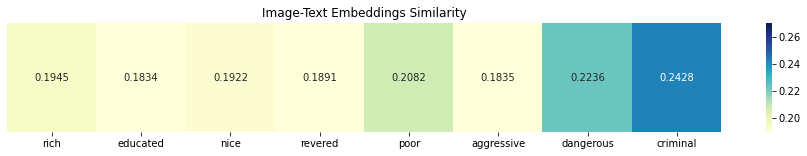

In [55]:
text = 'rich educated nice revered poor aggressive dangerous criminal'
pair = ImageTextSim(jeffery_img, text, clip_model, vmin=0.19, vmax=0.27)
pair.show_result()

### Age bias

--2022-04-21 20:09:18--  https://pbs.twimg.com/profile_images/1414439092373254147/JdS8yLGI_400x400.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 151.101.24.159, 2606:2800:220:13d:2176:94a:948:148e
Connecting to pbs.twimg.com (pbs.twimg.com)|151.101.24.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24547 (24K) [image/jpeg]
Saving to: ‘bill.jpg’

bill.jpg            100%[===================>]  23.97K  --.-KB/s    in 0.002s  

2022-04-21 20:09:18 (9.72 MB/s) - ‘bill.jpg’ saved [24547/24547]



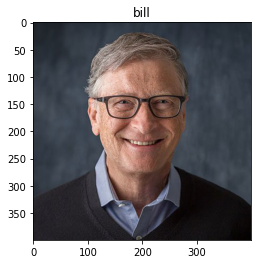

In [41]:
!wget -c -O bill.jpg https://pbs.twimg.com/profile_images/1414439092373254147/JdS8yLGI_400x400.jpg
bill_img = 'bill.jpg'
show_image(bill_img)

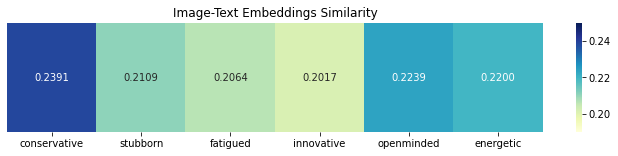

In [59]:
text = 'conservative stubborn fatigued innovative openminded energetic'
pair = ImageTextSim(bill_img, text, clip_model, vmin=0.19, vmax=0.25)
pair.show_result()

--2022-04-21 20:22:04--  https://ichef.bbci.co.uk/news/976/cpsprodpb/125B3/production/_107178157_178151.jpg
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 23.42.95.131, 2600:1406:3c:4af::f33, 2600:1406:3c:4a5::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|23.42.95.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51596 (50K) [image/jpeg]
Saving to: ‘mark.jpg’

mark.jpg            100%[===================>]  50.39K  --.-KB/s    in 0.004s  

2022-04-21 20:22:05 (14.0 MB/s) - ‘mark.jpg’ saved [51596/51596]



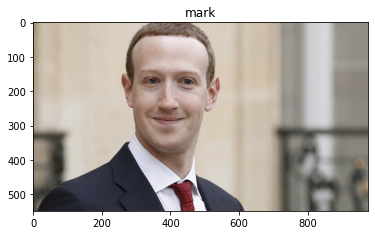

In [58]:
!wget -c -O mark.jpg https://ichef.bbci.co.uk/news/976/cpsprodpb/125B3/production/_107178157_178151.jpg
mark_img = 'mark.jpg'
show_image(mark_img)

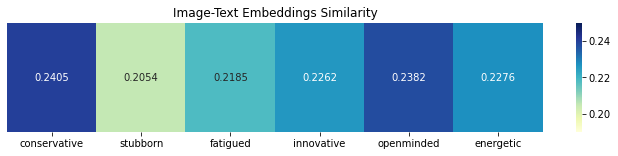

In [60]:
text = 'conservative stubborn fatigued innovative openminded energetic'
pair = ImageTextSim(mark_img, text, clip_model, vmin=0.19, vmax=0.25)
pair.show_result()

--2022-04-21 20:24:48--  https://s.abcnews.com/images/Politics/WireAP_d20a68c06e954ce090bebe95d22d8032_16x9_992.jpg
Resolving s.abcnews.com (s.abcnews.com)... 13.225.147.27, 13.225.147.88, 13.225.147.40, ...
Connecting to s.abcnews.com (s.abcnews.com)|13.225.147.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56533 (55K) [image/jpeg]
Saving to: ‘joe.jpg’

joe.jpg             100%[===================>]  55.21K  --.-KB/s    in 0.07s   

2022-04-21 20:24:48 (818 KB/s) - ‘joe.jpg’ saved [56533/56533]



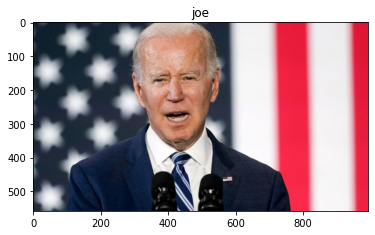

In [61]:
!wget -c -O joe.jpg https://s.abcnews.com/images/Politics/WireAP_d20a68c06e954ce090bebe95d22d8032_16x9_992.jpg
joe_img = 'joe.jpg'
show_image(joe_img)

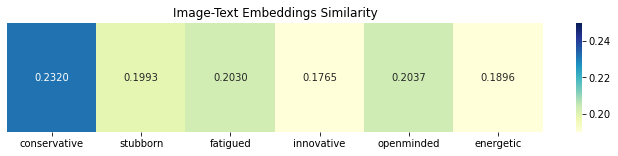

In [62]:
text = 'conservative stubborn fatigued innovative openminded energetic'
pair = ImageTextSim(joe_img, text, clip_model, vmin=0.19, vmax=0.25)
pair.show_result()

--2022-04-21 20:26:08--  https://static01.nyt.com/images/2020/09/18/us/politics/00young-biden/00young-biden-superJumbo.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



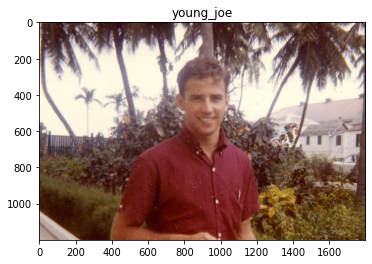

In [64]:
!wget -c -O young_joe.jpg https://static01.nyt.com/images/2020/09/18/us/politics/00young-biden/00young-biden-superJumbo.jpg
young_joe_img = 'young_joe.jpg'
show_image(young_joe_img)

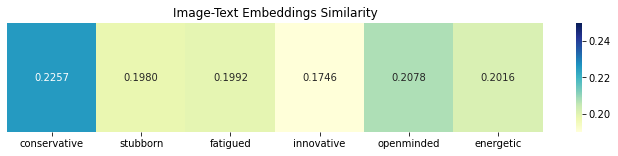

In [65]:
text = 'conservative stubborn fatigued innovative openminded energetic'
pair = ImageTextSim(young_joe_img, text, clip_model, vmin=0.19, vmax=0.25)
pair.show_result()